## **Assignment by: Ayesha Sahar (FA24-RAI-005)**

# **Paper Information**

**The paper selected was "A Comparative Study of Sentiment Classification Models for Greek Reviews", published on 4 September 2024, in the journal "big data and cognitive computing".**

The paper is linked [here](https://www.mdpi.com/2504-2289/8/9/107).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torch torchvision transformers datasets scikit-learn openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_excel('/content/drive/MyDrive/Skroutz_dataset.xlsx')
data.head()


,id,review,label
0,0,Πολύ καλό κατάστημα τόσο από κοντά όσο και...,Positive
1,1,Γρήγορη παραλαβή και φιλική εξυπηρέτηση.,Positive
2,2,Εύκολα γρήγορα απλά. Το προϊόν όπως περιγρά...,Positive
3,3,Πολύ ευχαριστημένη με την παράδοση. Επικοινω...,Positive
4,4,Όλα πήγαν καλά με την παραγγελία μου. Θα αγο...,Positive


In [5]:
data.shape

(6552, 3)

In [6]:
texts = data['review'].tolist()
labels = data['label'].tolist()

In [7]:
unique_labels = set(labels)
print(unique_labels)

{'Negative', 'Positive'}


In [8]:
label_counts = data['label'].value_counts()
print("\nCounts of each label:")
print(label_counts)


Counts of each label:
label
Positive    3276
Negative    3276
Name: count, dtype: int64


In [9]:
# Convert string labels to integers
label_mapping = {'Positive': 1, 'Negative': 0}
labels = [label_mapping[label] for label in data['label']]

In [10]:
# Tokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [11]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [12]:
def tokenize_data(texts, labels):
    tokens = tokenizer(
        texts, padding=True, truncation=True, max_length=200, return_tensors='pt'
    )
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"],
        "labels": torch.tensor(labels, dtype=torch.long)  # Ensure labels are long tensors
    }

train_data = tokenize_data(train_texts, train_labels)
test_data = tokenize_data(test_texts, test_labels)

In [13]:
# DataLoader
train_dataset = torch.utils.data.TensorDataset(
    train_data['input_ids'], train_data['attention_mask'], train_data['labels']
)

test_dataset = torch.utils.data.TensorDataset(
    test_data['input_ids'], test_data['attention_mask'], test_data['labels']
)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Check a batch from train_loader
for batch in train_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]
    print(f"Input IDs shape: {input_ids.shape}, Attention Mask shape: {attention_mask.shape}, Labels shape: {labels.shape}")
    break  # Only check the first batch

In [16]:
# Model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

# Training
epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collect predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

    # Compute training accuracy
    train_acc = accuracy_score(true_labels, predictions)

    # Print training metrics for the current epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Training Loss: {total_loss / len(train_loader):.4f}")
    print(f"  Training Accuracy: {train_acc:.4f}")

    # Evaluate on the testing set after each epoch
    model.eval()
    test_predictions, test_true_labels = [], []
    total_test_loss = 0  
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)  # Include labels for loss computation
            loss = outputs.loss
            total_test_loss += loss.item()

            # Collect predictions and labels
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_predictions.extend(preds)
            test_true_labels.extend(labels.cpu().numpy())

    # Compute testing accuracy
    test_acc = accuracy_score(test_true_labels, test_predictions)

    # Print testing metrics for the current epoch
    print(f"  Testing Loss: {total_test_loss / len(test_loader):.4f}")
    print(f"  Testing Accuracy: {test_acc:.4f}")


Epoch 1/4
  Training Loss: 0.3037
  Training Accuracy: 0.8775
  Testing Loss: 0.1627
  Testing Accuracy: 0.9382
Epoch 2/4
  Training Loss: 0.1326
  Training Accuracy: 0.9502
  Testing Loss: 0.1413
  Testing Accuracy: 0.9497
Epoch 3/4
  Training Loss: 0.0886
  Training Accuracy: 0.9687
  Testing Loss: 0.1424
  Testing Accuracy: 0.9512
Epoch 4/4
  Training Loss: 0.0609
  Training Accuracy: 0.9798
  Testing Loss: 0.1428
  Testing Accuracy: 0.9535


In [18]:
# Evaluation
def evaluate_model(loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    return acc, precision, recall, f1

train_acc, train_prec, train_rec, train_f1 = evaluate_model(train_loader)
test_acc, test_prec, test_rec, test_f1 = evaluate_model(test_loader)

print(f"Train Accuracy: {train_acc}, Precision: {train_prec}, Recall: {train_rec}, F1: {train_f1}")
print(f"Test Accuracy: {test_acc}, Precision: {test_prec}, Recall: {test_rec}, F1: {test_f1}")


Train Accuracy: 0.9931310818546079, Precision: 0.9923518164435946, Recall: 0.9938720796629644, F1: 0.9931113662456946
Test Accuracy: 0.9534706331045004, Precision: 0.9441176470588235, Recall: 0.9654135338345865, F1: 0.9546468401486989


# **Detailed Comparison of Results**

### Paper's results - Epoch 1:
- **Training Loss:** 0.26
- **Training Accuracy:** 89.66%
- **Testing Loss:** 0.15
- **Testing Accuracy:** 94.74%

### My results - Epoch 1:
- **Training Loss:** 0.3037
- **Training Accuracy:** 87.75%
- **Testing Loss:** 0.1627
- **Testing Accuracy:** 93.82%

<hr/>

### Paper's results - Epoch 2:
- **Training Loss:** 0.11
- **Training Accuracy:** 96.01%
- **Testing Loss:** 0.12
- **Testing Accuracy:** 95.42%

### My results - Epoch 2:
- **Training Loss:** 0.1326
- **Training Accuracy:** 95.02%
- **Testing Loss:** 0.1413
- **Testing Accuracy:** 94.97%

<hr/>

### Paper's results - Epoch 3:
- **Training Loss:** 0.08
- **Training Accuracy:** 97.25%
- **Testing Loss:** 0.12
- **Testing Accuracy:** 95.88%

### My results - Epoch 3:
- **Training Loss:** 0.0886
- **Training Accuracy:** 96.87%
- **Testing Loss:** 0.1424
- **Testing Accuracy:** 95.12%

<hr/>

### Paper's results - Epoch 4:
- **Training Loss:** 0.05
- **Training Accuracy:** 98.24%
- **Testing Loss:** 0.13
- **Testing Accuracy:** 96.03%


### My results - Epoch 4:
- **Training Loss:** 0.0609
- **Training Accuracy:** 97.98%
- **Testing Loss:** 0.1428
- **Testing Accuracy:** 95.35%

## **Final results**

### Training:
- **Accuracy:** 99.31%
- **Precision:** 99.24%
- **Recall:** 99.39%
- **F1 Score:** 99.31%

### Testing:
- **Accuracy:** 95.35%
- **Precision:** 94.41%
- **Recall:** 96.54%
- **F1 Score:** 95.46%


## **Visualizing the results**

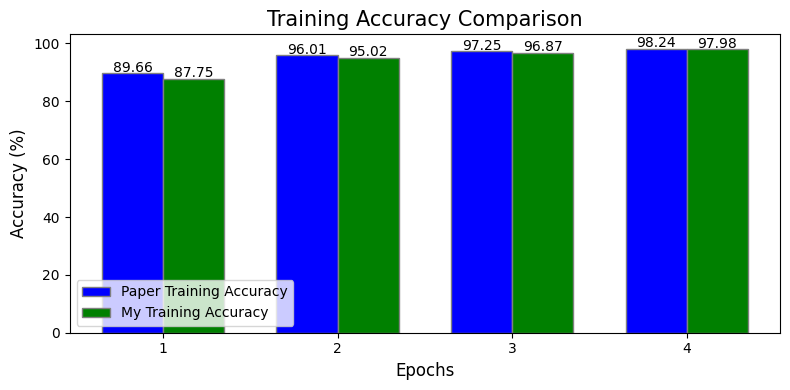

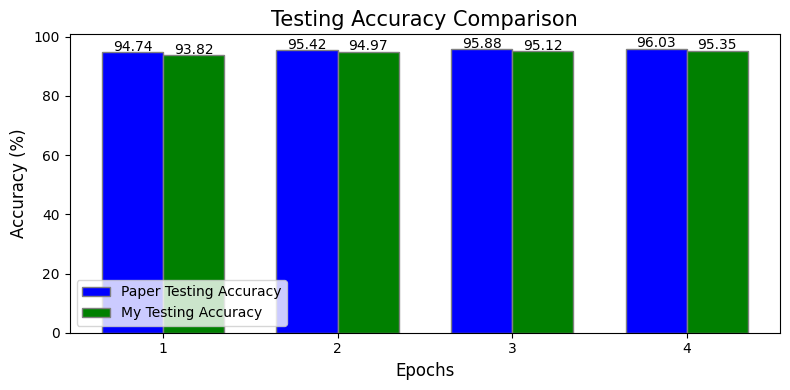

In [5]:
epochs = [1, 2, 3, 4]
paper_training_accuracy = [89.66, 96.01, 97.25, 98.24]
my_training_accuracy = [87.75, 95.02, 96.87, 97.98]
paper_testing_accuracy = [94.74, 95.42, 95.88, 96.03]
my_testing_accuracy = [93.82, 94.97, 95.12, 95.35]

bar_width = 0.35

r1 = np.arange(len(epochs))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(8, 4))
bars1 = plt.bar(r1, paper_training_accuracy, color='b', width=bar_width, edgecolor='grey', label='Paper Training Accuracy')
bars2 = plt.bar(r2, my_training_accuracy, color='g', width=bar_width, edgecolor='grey', label='My Training Accuracy')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}', ha='center', fontsize=10)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}', ha='center', fontsize=10)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training Accuracy Comparison', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(epochs))], epochs)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
bars1 = plt.bar(r1, paper_testing_accuracy, color='b', width=bar_width, edgecolor='grey', label='Paper Testing Accuracy')
bars2 = plt.bar(r2, my_testing_accuracy, color='g', width=bar_width, edgecolor='grey', label='My Testing Accuracy')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}', ha='center', fontsize=10)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{bar.get_height():.2f}', ha='center', fontsize=10)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Testing Accuracy Comparison', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(epochs))], epochs)
plt.legend()
plt.tight_layout()
plt.show()
